# The Mechanical Cause of Box Beam's Bifurcation Break

***

In this notebook we demonstrate the mechanical cause of the bifurcation break observed for both the [unreinforced](06_Nonlinear_Buckling_Method_Verification.ipynb) and the [reinforced box beam](08_Nonlinear_Buckling_of_a_Reinforced_Box_Beam.ipynb) under a concentrated bending load applied at the tip.

* [Introduction](#introduction)
* [Unreinforced box beam](#unreinforced)
    * [Setup of the numerical model](#unreinforced-numerical-model)
    * [Linear buckling analysis](#unreinforced-linear-buckling)
    * [Nonlinear analysis](#unreinforced-nonlinear-analysis)
    * [Stress results](#unreinforced-stress-results)
* [Reinforced box beam](#reinforced)
    * [Setup of the numerical model](#reinforced-numerical-model)
    * [Linear buckling analysis](#reinforced-linear-buckling)
    * [Nonlinear analysis](#reinforced-nonlinear-analysis)
    * [Stress results](#reinforced-stress-results)


## Introduction <a name="introduction"></a>

***

We make the hypothesis that bifurcation break is caused by an asymmetry of the load about the midplane of the top skin, in addition to the global top-down asymmetry of the box beam introduced by the concentrated bending load.

We can observe this in the figure below, where we can see a side view of the section of an unreinforced box beam at the front-rear plane of symmetry. The concentrated tip load $P$ causes a deflection of our box beam that brings the top skin under compression and the bottom skin under tension.

In this configuration, the axial stresses in the spars at a given longitudinal section must vary from positive to negative along the local height. Also the axial stresses in the skins must have an analogous variation between their top and bottom planes. However, in this case the variation is between two positive values for the bottom skin and between two negative values for the top skin. As a consequence there is no symmetry of the stresses, and thus of the internal loads, about the midplane of the top skin, which causes the bifurcation point to break.

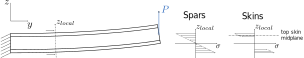

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces
SVG(filename=os.path.join('resources', '10_BoxBeamStresses.svg'))

We are going to test this hypothesis on both the unreinforced and the reinforced box beam configurations.

## Unreinforced box beam <a name="unreinforced"></a>

***

### Setup of the numerical model <a name="unreinforced-numerical-model"></a>

We consider an unreinforced box beam with the same geometry of the ones used in our previous notebooks.

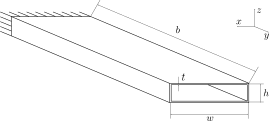

In [76]:
SVG(filename=os.path.join('resources', '04_BoxBeamGeometry.svg'))

In [77]:
AR = 9.   # aspect ratio - 2*b/w (the span of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
b = AR*w/2  # span [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.2f} m\n- span: {b/1e3:.2f} m\n- height: {h/1e3:.2f} m\n- wall thickness: {t:.2f} mm')

Box beam dimensions:
- width: 1.00 m
- span: 4.50 m
- height: 0.20 m
- wall thickness: 4.00 mm


We do the same for the material properties.

In [78]:
rho = 2780e-12  # density [ton/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio

We create a mesh of quadrilateral elements using the function `mesh_box_pyvista` from the `box_beam_utils` module. We prescribe an edge length of 86 mm based on the results of a previous [mesh convergence study](04_Nonlinear_Buckling_Box_Beam.ipynb).

In [79]:
from resources import box_beam_utils

edge_length = 86  # [mm]
unreinforced_box_beam_mesh = box_beam_utils.mesh_box_pyvista(width=w, span=b, height=h, edge_length=edge_length)
nodes_coordinates_array = unreinforced_box_beam_mesh.points
nodes_connectivity_matrix = unreinforced_box_beam_mesh.faces.reshape(-1, 5)[:, 1:]

Now we create a base `BDF` object where we define fixed boundary conditions at the root of the box beam.

In [80]:
# Create BDF object
unreinforced_box_beam = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
# Print cards of BDF object
print(unreinforced_box_beam.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 1760

bdf.elements: 0
  CQUAD4   : 1728

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


Then we apply a concentrated tip load at the center of the tip section as shown below. We use a RBE3 element to connect the nodes along the tip section to the node in the center.

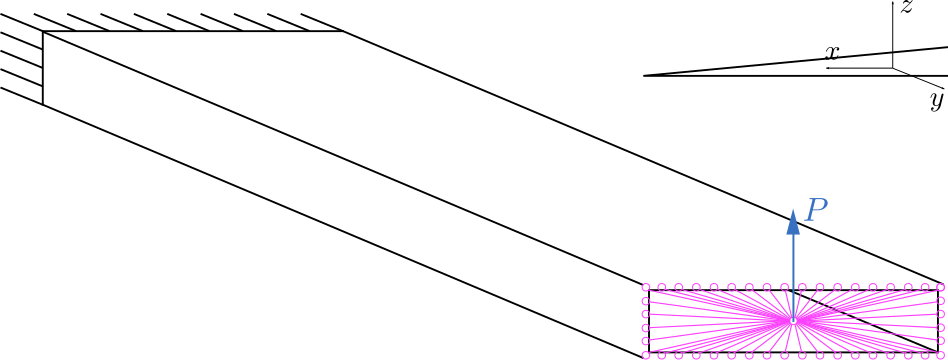

In [98]:
SVG(filename=os.path.join('resources', '04_BoxBeamConcentratedLoad.svg'))

In [81]:
import numpy as np
from resources import pynastran_utils

# Find id of tip nodes
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tolerance = edge_length/100
tip_nodes_ids = nodes_ids[np.abs(nodes_coordinates_array[:,1] - b) < tolerance]
# Add master node of tip section
tip_section_master_node_id = np.amax(nodes_ids) + 1
unreinforced_box_beam.add_grid(tip_section_master_node_id, [w/2, b, 0.])
# Add RBE2 to connect master node with outer nodes of tip rib
rbe2_eid = len(unreinforced_box_beam.elements) + 1
unreinforced_box_beam.add_rbe2(eid=rbe2_eid, gn=tip_section_master_node_id, cm='123456', Gmi=tip_nodes_ids)
# Add concentrated force
force_set_id = 11
force_direction = [0., 0., 1.]
pynastran_utils.add_unitary_force(bdf_object=unreinforced_box_beam, nodes_ids=[tip_section_master_node_id], set_id=force_set_id, direction_vector=force_direction)

### Linear buckling analysis <a name="unreinforced-linear-buckling"></a>

Buckling load: 1657 N
Buckling mode:


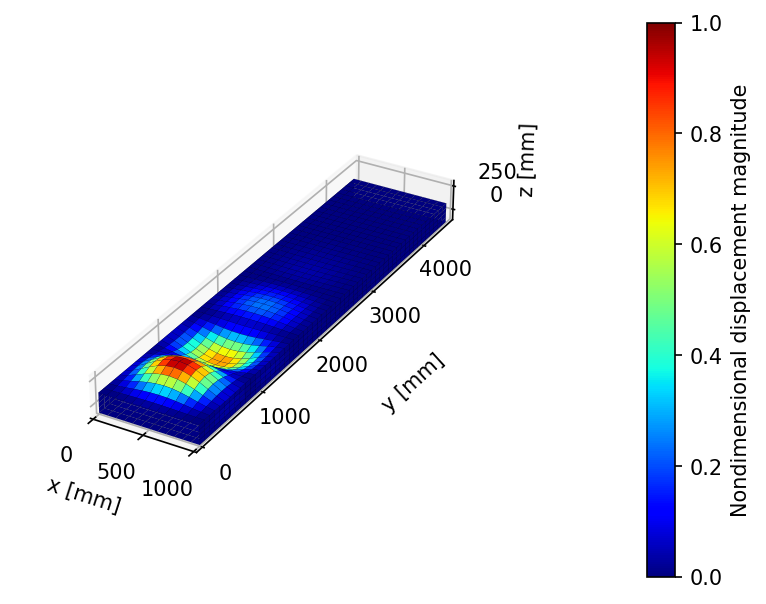

In [82]:
import matplotlib.pyplot as plt

# Define name of analysis directory
analysis_directory_name = '10_The_Mechanical_Cause_of_Bifurcation_Break'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)
# Calculate linear buckling load
plt.rcParams['figure.dpi'] = 150  # set default dpi of figures
sol_105_buckling_load = box_beam_utils.calculate_linear_buckling_load(bdf_object=unreinforced_box_beam.__deepcopy__({}), static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name='unreinforced_box_beam_linear_bukling', run_flag=False, plot_shape=True)

### Nonlinear analysis <a name="unreinforced-nonlinear-buckling"></a>

In [83]:
# Set up nonlinear analysis with arc-length method
pynastran_utils.set_up_arc_length_method(bdf_object=unreinforced_box_beam, ninc=100, eps_p=1e-3, eps_w=1e-7, maxalr=1.1, desiter=5, maxinc=100)
# Store stress results of all elements in the op2 file
unreinforced_box_beam.case_control_deck.subcases[0].add_result_type('STRESS', 'ALL', ['PRINT'])
# Define total applied load
load_set_id = force_set_id+1
load_magnitude = sol_105_buckling_load*2
unreinforced_box_beam.add_load(sid=load_set_id, scale=1., scale_factors=[load_magnitude], load_ids=[force_set_id])
# Create subcase
subcase_id = 1
pynastran_utils.create_static_load_subcase(bdf_object=unreinforced_box_beam, subcase_id=subcase_id, load_set_id=load_set_id)

Run analysis.

In [84]:
# Run analysis
input_filename = 'unreinforced_box_beam_nonlinear_analysis'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=unreinforced_box_beam, bdf_filename=input_filename, run_flag=False)

Plot load-displacement diagram and final deformation shape.

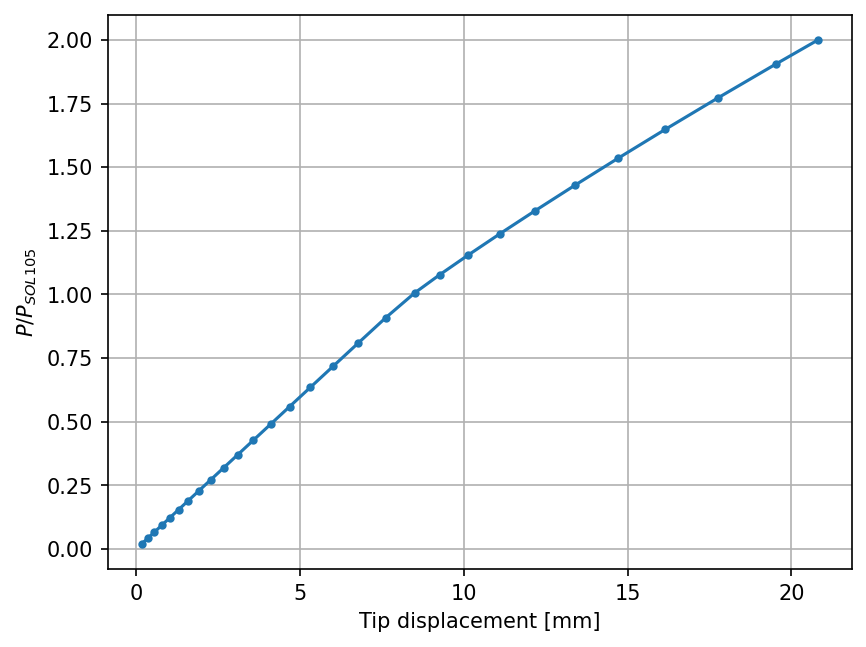

(<Figure size 960x720 with 2 Axes>,
 <Axes3DSubplot:xlabel='x [mm]', ylabel='y [mm]'>)

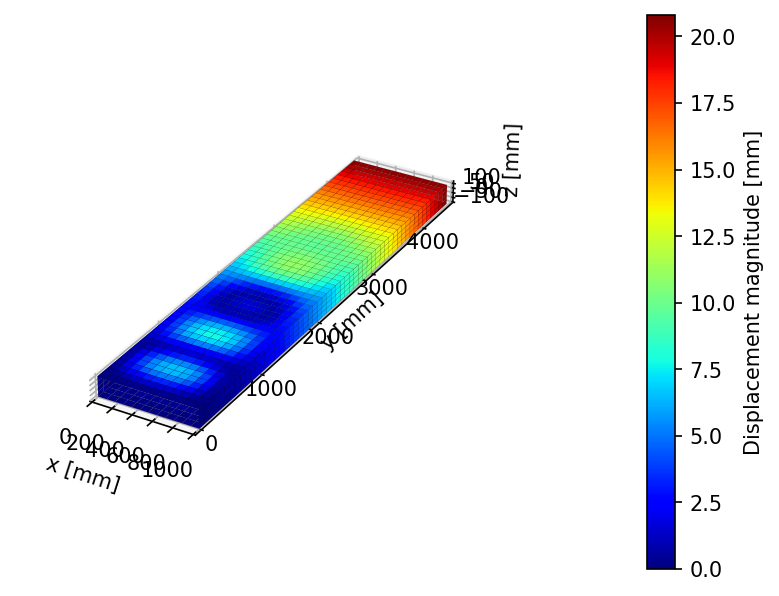

In [85]:
from pyNastran.op2.op2 import read_op2

# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=False)
# Find load and displacement history
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=tip_section_master_node_id)
# Select translation along z as the load and displacement components to plot
load_component_index = 2
displacement_component_index = 2
# Plot load-displacement diagram
_, ax = plt.subplots()
ax.plot(displacements[1][:,displacement_component_index], loads[1][:, load_component_index]/sol_105_buckling_load, '.-')
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.grid()
plt.show()
# Plot final static deformation
pynastran_utils.plot_static_deformation(op2_object=op2_output, subcase_id=subcase_id)

### Stress results <a name="unreinforced-stress-results"></a>

Plot stress profile.

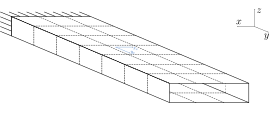

In [86]:
SVG(filename=os.path.join('resources', '10_BoxBeamElementCoordinateSystem.svg'))

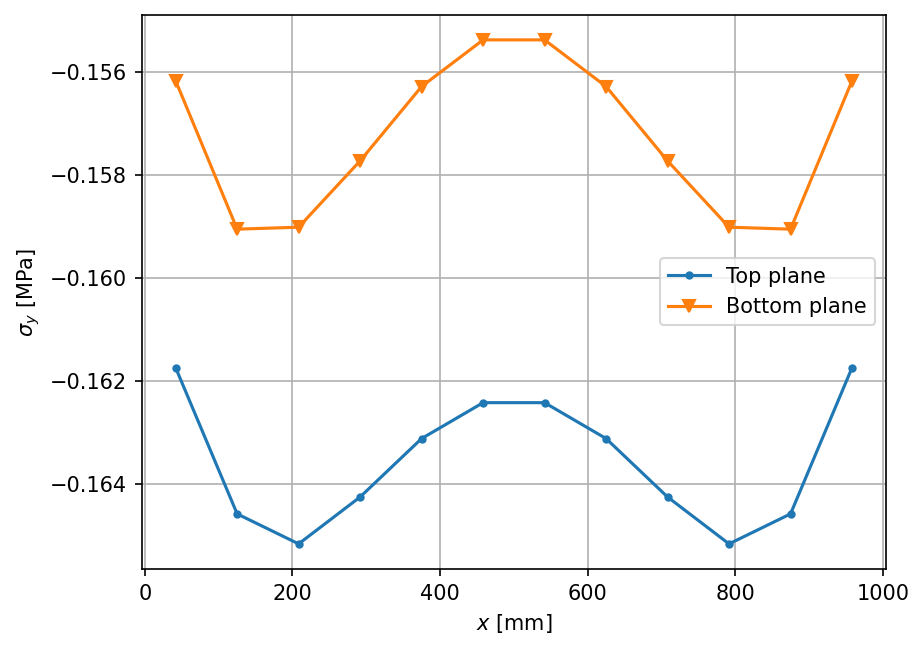

In [87]:
stress_profile_y_location = 400  # [mm]
elements_nodes_coordinates = np.stack([e.get_node_positions() for e in op2_output.elements.values()], axis=0)
stress_profile_element_ids = np.where([(np.amin(e[:, 1])<stress_profile_y_location) & (np.amax(e[:, 1])>stress_profile_y_location) & (all(np.abs(e[:, 2] - h/2)<tolerance)) for e in elements_nodes_coordinates])[0] + 1
stress_profile_data = np.stack([op2_output.cquad4_stress[subcase_id].data[0, np.where(op2_output.cquad4_stress[subcase_id].element_node == eid)[0], :] for eid in stress_profile_element_ids], axis=0)
elements_centroid_x_location = np.array([op2_output.elements[eid].Centroid()[0] for eid in stress_profile_element_ids])
#
_, ax = plt.subplots()
ax.plot(elements_centroid_x_location, stress_profile_data[:, 0, 2], '.-', label='Top plane')
ax.plot(elements_centroid_x_location, stress_profile_data[:, 1, 2], 'v-', label='Bottom plane')
ax.legend()
plt.xlabel('$x$ [mm]')
plt.ylabel('$\sigma_y$ [MPa]')
plt.grid()
plt.show()

## Reinforced box beam <a name="reinforced"></a>

***

### Geometry

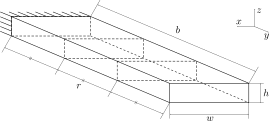

In [88]:
SVG(filename=os.path.join('resources', '08_ReinforcedBoxBeamGeometry.svg'))

In [89]:
# Prescribed spacing
ribs_spacing = w/2
# Number of ribs based on prescribed spacing
no_ribs = int(np.ceil(b/ribs_spacing)) + 1
print(f'Number of ribs: {no_ribs:.0f}')
# Find prescribed ribs location
ribs_y_locations = np.linspace(0, b, no_ribs)

Number of ribs: 10


### Mesh

In [90]:
edge_length = 49  # [mm]
reinforced_box_beam_mesh = box_beam_utils.mesh_box_beam_pyvista(ribs_y_coordinates=ribs_y_locations, width=w, height=h, edge_length=edge_length)
nodes_coordinates_array = reinforced_box_beam_mesh.points
nodes_connectivity_matrix = reinforced_box_beam_mesh.faces.reshape(-1, 5)[:, 1:]

### Base input with boundary conditions

In [91]:
# Create BDF object
reinforced_box_beam = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
# Print cards of BDF object
print(reinforced_box_beam.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 7154

bdf.elements: 0
  CQUAD4   : 7368

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


### Load

In [92]:
# Find outer nodes of tip rib
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tolerance = edge_length/100
outer_tip_nodes_ids = nodes_ids[(np.abs(nodes_coordinates_array[:, 1] - b) < tolerance) & ((nodes_coordinates_array[:, 0] < tolerance) | (np.abs(nodes_coordinates_array[:, 0] - w) < tolerance) | (np.abs(nodes_coordinates_array[:, 2] - h/2) < tolerance) | (np.abs(nodes_coordinates_array[:, 2] + h/2) < tolerance))]
# Add master node of tip section
tip_section_master_node_id = np.amax(nodes_ids) + 1
reinforced_box_beam.add_grid(tip_section_master_node_id, [w/2, b, 0.])
# Add RBE3 to connect master node with outer nodes of tip rib
rbe3_eid = len(reinforced_box_beam.elements) + 1
reinforced_box_beam.add_rbe3(eid=rbe3_eid, refgrid=tip_section_master_node_id, refc='123456', weights=[1.]*len(outer_tip_nodes_ids), comps=['123456']*len(outer_tip_nodes_ids), Gijs=outer_tip_nodes_ids)
# Add concentrated force
pynastran_utils.add_unitary_force(bdf_object=reinforced_box_beam, nodes_ids=[tip_section_master_node_id], set_id=force_set_id, direction_vector=force_direction)

### Linear buckling analysis

Buckling load: 3094 N
Buckling mode:


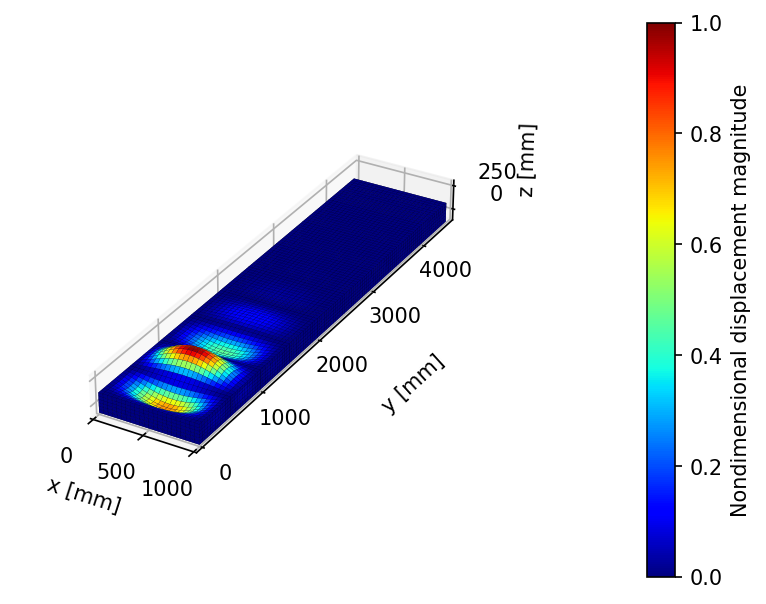

In [93]:
sol_105_buckling_load = box_beam_utils.calculate_linear_buckling_load(bdf_object=reinforced_box_beam.__deepcopy__({}), static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name='reinforced_box_beam_linear_bukling', run_flag=False, plot_shape=True)

### Nonlinear analysis

In [94]:
# Set up nonlinear analysis with arc-length method
pynastran_utils.set_up_arc_length_method(bdf_object=reinforced_box_beam, ninc=100, eps_p=1e-3, eps_w=1e-7, maxalr=1.1, desiter=5, maxinc=100)
# Store stress results of all elements in the op2 file
reinforced_box_beam.case_control_deck.subcases[0].add_result_type('STRESS', 'ALL', ['PRINT'])
# Define total applied load
load_magnitude = sol_105_buckling_load*2
reinforced_box_beam.add_load(sid=load_set_id, scale=1., scale_factors=[load_magnitude], load_ids=[force_set_id])
# Create subcase
pynastran_utils.create_static_load_subcase(bdf_object=reinforced_box_beam, subcase_id=subcase_id, load_set_id=load_set_id)
# Run analysis
input_filename = 'reinforced_box_beam_nonlinear_analysis'
pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=reinforced_box_beam, bdf_filename=input_filename, run_flag=False)

Plot load-displacement diagram and final deformation shape.

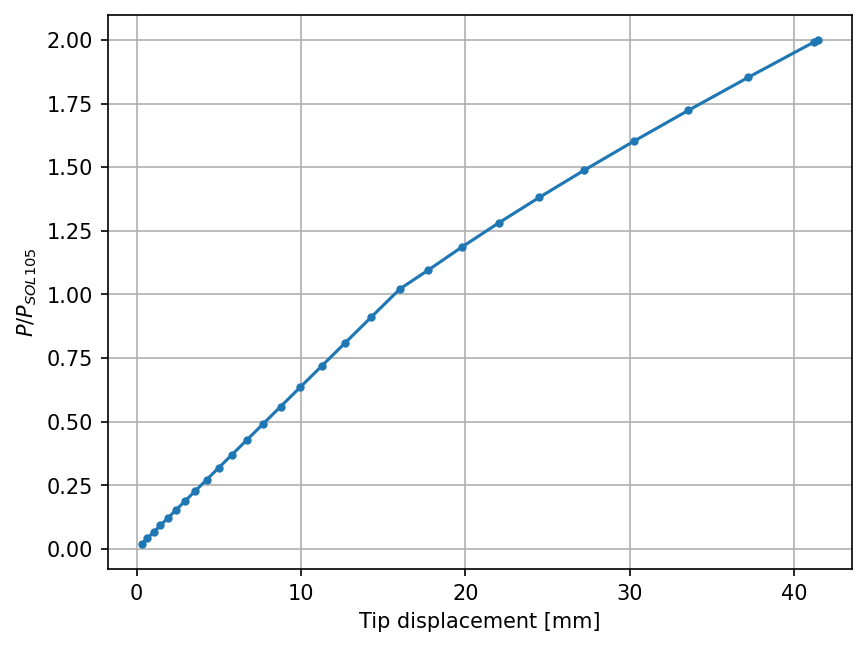

(<Figure size 960x720 with 2 Axes>,
 <Axes3DSubplot:xlabel='x [mm]', ylabel='y [mm]'>)

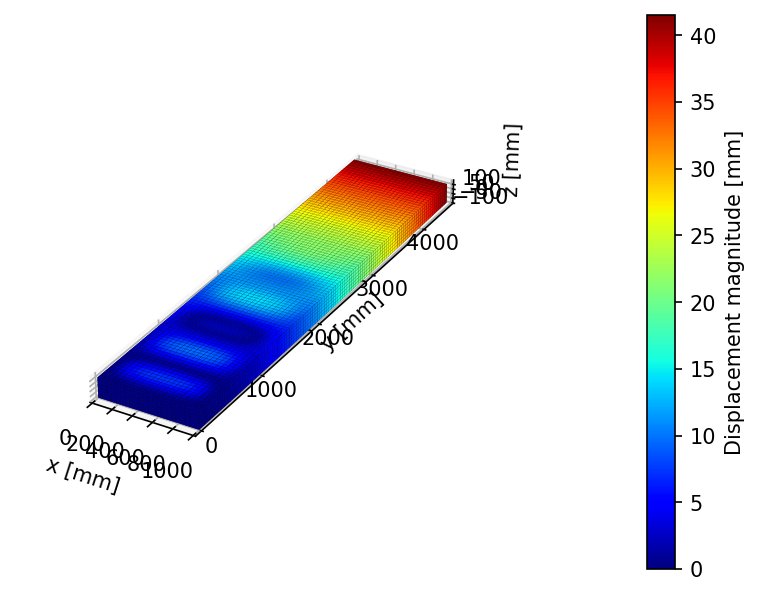

In [95]:
# Read op2 file
op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
op2_output = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=False)
# Find load and displacement history
_, loads, displacements = pynastran_utils.read_load_displacement_history_from_op2(op2_object=op2_output, displacement_node_id=tip_section_master_node_id)
# Select translation along z as the load and displacement components to plot
load_component_index = 2
displacement_component_index = 2
# Plot load-displacement diagram
_, ax = plt.subplots()
ax.plot(displacements[1][:,displacement_component_index], loads[1][:, load_component_index]/sol_105_buckling_load, '.-')
plt.xlabel('Tip displacement [mm]')
plt.ylabel('$P/P_{SOL 105}$')
plt.grid()
plt.show()
# Plot final static deformation
pynastran_utils.plot_static_deformation(op2_object=op2_output, subcase_id=subcase_id)

Plot stress profile.

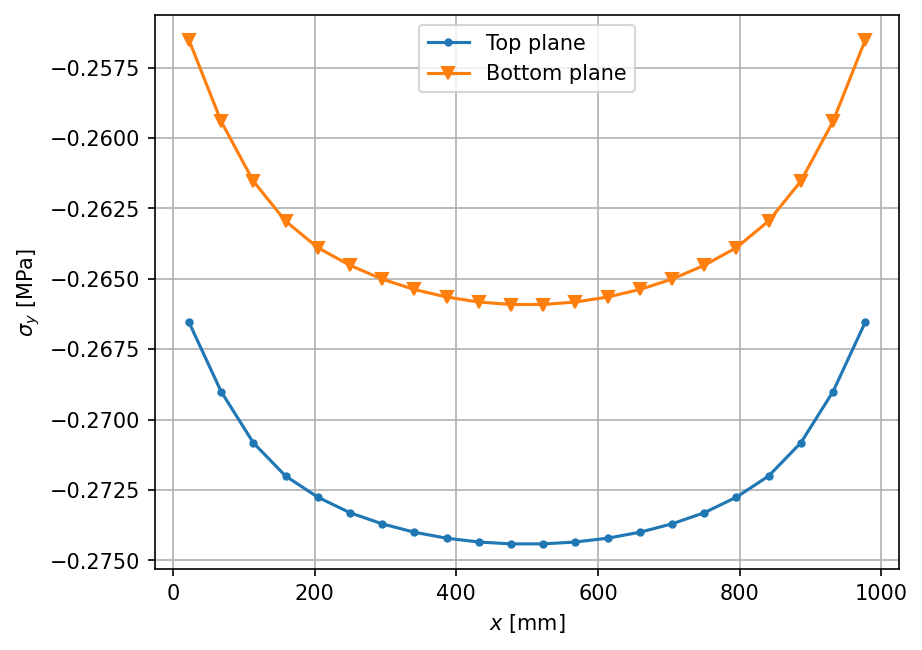

In [96]:
stress_profile_y_location = 800  # [mm]
elements_nodes_coordinates = np.stack([e.get_node_positions() for e in op2_output.elements.values()], axis=0)
stress_profile_element_ids = np.where([(np.amin(e[:, 1])<stress_profile_y_location) & (np.amax(e[:, 1])>stress_profile_y_location) & (all(np.abs(e[:, 2] - h/2)<tolerance)) for e in elements_nodes_coordinates])[0] + 1
stress_profile_data = np.stack([op2_output.cquad4_stress[subcase_id].data[0, np.where(op2_output.cquad4_stress[subcase_id].element_node == eid)[0], :] for eid in stress_profile_element_ids], axis=0)
elements_centroid_x_location = np.array([op2_output.elements[eid].Centroid()[0] for eid in stress_profile_element_ids])
#
_, ax = plt.subplots()
ax.plot(elements_centroid_x_location, stress_profile_data[:, 0, 2], '.-', label='Top plane')
ax.plot(elements_centroid_x_location, stress_profile_data[:, 1, 2], 'v-', label='Bottom plane')
ax.legend()
plt.xlabel('$x$ [mm]')
plt.ylabel('$\sigma_y$ [MPa]')
plt.grid()
plt.show()

***

The cell below executes the style for this notebook. We use a slightly modified version of the custom style found on the GitHub of [barbagroup](https://github.com/barbagroup), [@LorenaABarba](https://twitter.com/LorenaABarba).

In [97]:
from IPython.core.display import HTML
def css_styling():
    styles = open(os.path.join(os.pardir, 'styles', 'custom.css'), 'r').read()
    return HTML(styles)
css_styling()